In [2]:
#!/usr/bin/env python3
import torch
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from pathlib import Path

In [3]:
def load_data(data_path, metadata_path):
    """Load training data and metadata"""
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    data = torch.load(data_path)
    return data, metadata

def process_data(data):
    """Convert list of tuples to stacked tensors"""
    x_s_list = [sample[0] for sample in data]
    x_t_list = [sample[1] for sample in data]
    y_list = [sample[2] for sample in data]
    
    x_s = torch.stack(x_s_list)
    x_t = torch.stack(x_t_list)
    y = torch.stack(y_list)
    
    return x_s, x_t, y

In [4]:
def visualize_train_test_distributions(train_data, test_data, metadata, save_dir="./temp"):
    """Visualize distributions comparing train and test sets"""
    
    # Process both datasets
    train_x_s, train_x_t, train_y = process_data(train_data)
    test_x_s, test_x_t, test_y = process_data(test_data)
    
    x_s_dim = metadata['sample_shape']['x_s_dim']
    x_t_dim = metadata['sample_shape']['x_t_dim']
    y_dim = metadata['sample_shape']['y_dim']
    
    print(f"Train data shapes:")
    print(f"  x_s: {train_x_s.shape}, x_t: {train_x_t.shape}, y: {train_y.shape}")
    print(f"Test data shapes:")
    print(f"  x_s: {test_x_s.shape}, x_t: {test_x_t.shape}, y: {test_y.shape}")
    
    # Visualize x_s dimensions
    if x_s_dim > 0:
        fig, axes = plt.subplots(2, (x_s_dim + 1) // 2, figsize=(20, 10))
        if x_s_dim == 1:
            axes = [axes]
        elif x_s_dim <= 2:
            axes = axes.flatten()
        else:
            axes = axes.flatten()
        
        for i in range(x_s_dim):
            ax = axes[i] if x_s_dim > 1 else axes[0]
            
            # Plot both train and test
            ax.hist(train_x_s[:, i].numpy(), bins=50, alpha=0.6, label='Train', 
                   color='blue', edgecolor='black', density=True)
            ax.hist(test_x_s[:, i].numpy(), bins=50, alpha=0.6, label='Test', 
                   color='red', edgecolor='black', density=True)
            
            ax.set_title(f'x_s dimension {i}')
            ax.set_xlabel('Value')
            ax.set_ylabel('Density')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # Hide unused subplots
        for i in range(x_s_dim, len(axes)):
            axes[i].set_visible(False)
        
        plt.suptitle('x_s Distributions: Train vs Test', fontsize=16)
        plt.tight_layout()
        plt.savefig(f"{save_dir}/x_s_train_test_distributions.png", dpi=300, bbox_inches='tight')
        plt.show()
    
    # Visualize x_t dimensions
    if x_t_dim > 0:
        fig, axes = plt.subplots(1, x_t_dim, figsize=(5 * x_t_dim, 5))
        if x_t_dim == 1:
            axes = [axes]
        
        for i in range(x_t_dim):
            ax = axes[i] if x_t_dim > 1 else axes[0]
            
            ax.hist(train_x_t[:, i].numpy(), bins=50, alpha=0.6, label='Train', 
                   color='blue', edgecolor='black', density=True)
            ax.hist(test_x_t[:, i].numpy(), bins=50, alpha=0.6, label='Test', 
                   color='red', edgecolor='black', density=True)
            
            ax.set_title(f'x_t dimension {i}')
            ax.set_xlabel('Value')
            ax.set_ylabel('Density')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.suptitle('x_t Distributions: Train vs Test', fontsize=16)
        plt.tight_layout()
        plt.savefig(f"{save_dir}/x_t_train_test_distributions.png", dpi=300, bbox_inches='tight')
        plt.show()
    
    # Visualize y dimensions
    if y_dim > 0:
        fig, axes = plt.subplots(1, y_dim, figsize=(5 * y_dim, 5))
        if y_dim == 1:
            axes = [axes]
        
        for i in range(y_dim):
            ax = axes[i] if y_dim > 1 else axes[0]
            
            ax.hist(train_y[:, i].numpy(), bins=50, alpha=0.6, label='Train', 
                   color='blue', edgecolor='black', density=True)
            ax.hist(test_y[:, i].numpy(), bins=50, alpha=0.6, label='Test', 
                   color='red', edgecolor='black', density=True)
            
            ax.set_title(f'y dimension {i}')
            ax.set_xlabel('Value')
            ax.set_ylabel('Density')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.suptitle('y Distributions: Train vs Test', fontsize=16)
        plt.tight_layout()
        plt.savefig(f"{save_dir}/y_train_test_distributions.png", dpi=300, bbox_inches='tight')
        plt.show()
    
    # Print comparative statistics
    print("\n" + "="*80)
    print("COMPARATIVE STATISTICS: TRAIN vs TEST")
    print("="*80)
    
    print("\nx_s statistics:")
    for i in range(x_s_dim):
        train_dim = train_x_s[:, i]
        test_dim = test_x_s[:, i]
        print(f"  Dimension {i}:")
        print(f"    Train: mean={train_dim.mean():.4f}, std={train_dim.std():.4f}, "
              f"min={train_dim.min():.4f}, max={train_dim.max():.4f}")
        print(f"    Test:  mean={test_dim.mean():.4f}, std={test_dim.std():.4f}, "
              f"min={test_dim.min():.4f}, max={test_dim.max():.4f}")
        
        # Check for distribution shift
        mean_diff = abs(train_dim.mean() - test_dim.mean())
        std_diff = abs(train_dim.std() - test_dim.std())
        print(f"    Diff:  mean_diff={mean_diff:.4f}, std_diff={std_diff:.4f}")
        
        if mean_diff > 0.1 * train_dim.std() or std_diff > 0.1 * train_dim.std():
            print(f"    ⚠️  WARNING: Potential distribution shift detected!")
        print()
    
    print("x_t statistics:")
    for i in range(x_t_dim):
        train_dim = train_x_t[:, i]
        test_dim = test_x_t[:, i]
        print(f"  Dimension {i}:")
        print(f"    Train: mean={train_dim.mean():.4f}, std={train_dim.std():.4f}, "
              f"min={train_dim.min():.4f}, max={train_dim.max():.4f}")
        print(f"    Test:  mean={test_dim.mean():.4f}, std={test_dim.std():.4f}, "
              f"min={test_dim.min():.4f}, max={test_dim.max():.4f}")
        
        mean_diff = abs(train_dim.mean() - test_dim.mean())
        std_diff = abs(train_dim.std() - test_dim.std())
        print(f"    Diff:  mean_diff={mean_diff:.4f}, std_diff={std_diff:.4f}")
        
        if mean_diff > 0.1 * train_dim.std() or std_diff > 0.1 * train_dim.std():
            print(f"    ⚠️  WARNING: Potential distribution shift detected!")
        print()
    
    print("y statistics:")
    for i in range(y_dim):
        train_dim = train_y[:, i]
        test_dim = test_y[:, i]
        print(f"  Dimension {i}:")
        print(f"    Train: mean={train_dim.mean():.4f}, std={train_dim.std():.4f}, "
              f"min={train_dim.min():.4f}, max={train_dim.max():.4f}")
        print(f"    Test:  mean={test_dim.mean():.4f}, std={test_dim.std():.4f}, "
              f"min={test_dim.min():.4f}, max={test_dim.max():.4f}")
        
        mean_diff = abs(train_dim.mean() - test_dim.mean())
        std_diff = abs(train_dim.std() - test_dim.std())
        print(f"    Diff:  mean_diff={mean_diff:.4f}, std_diff={std_diff:.4f}")
        
        if mean_diff > 0.1 * train_dim.std() or std_diff > 0.1 * train_dim.std():
            print(f"    ⚠️  WARNING: Potential distribution shift detected!")
        print()

Loading training data...
Loading test data...
Generating comparative distribution plots...
Train data shapes:
  x_s: torch.Size([648, 7]), x_t: torch.Size([648, 2]), y: torch.Size([648, 2])
Test data shapes:
  x_s: torch.Size([72, 7]), x_t: torch.Size([72, 2]), y: torch.Size([72, 2])


/tmp/ipykernel_1252498/2959475248.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)


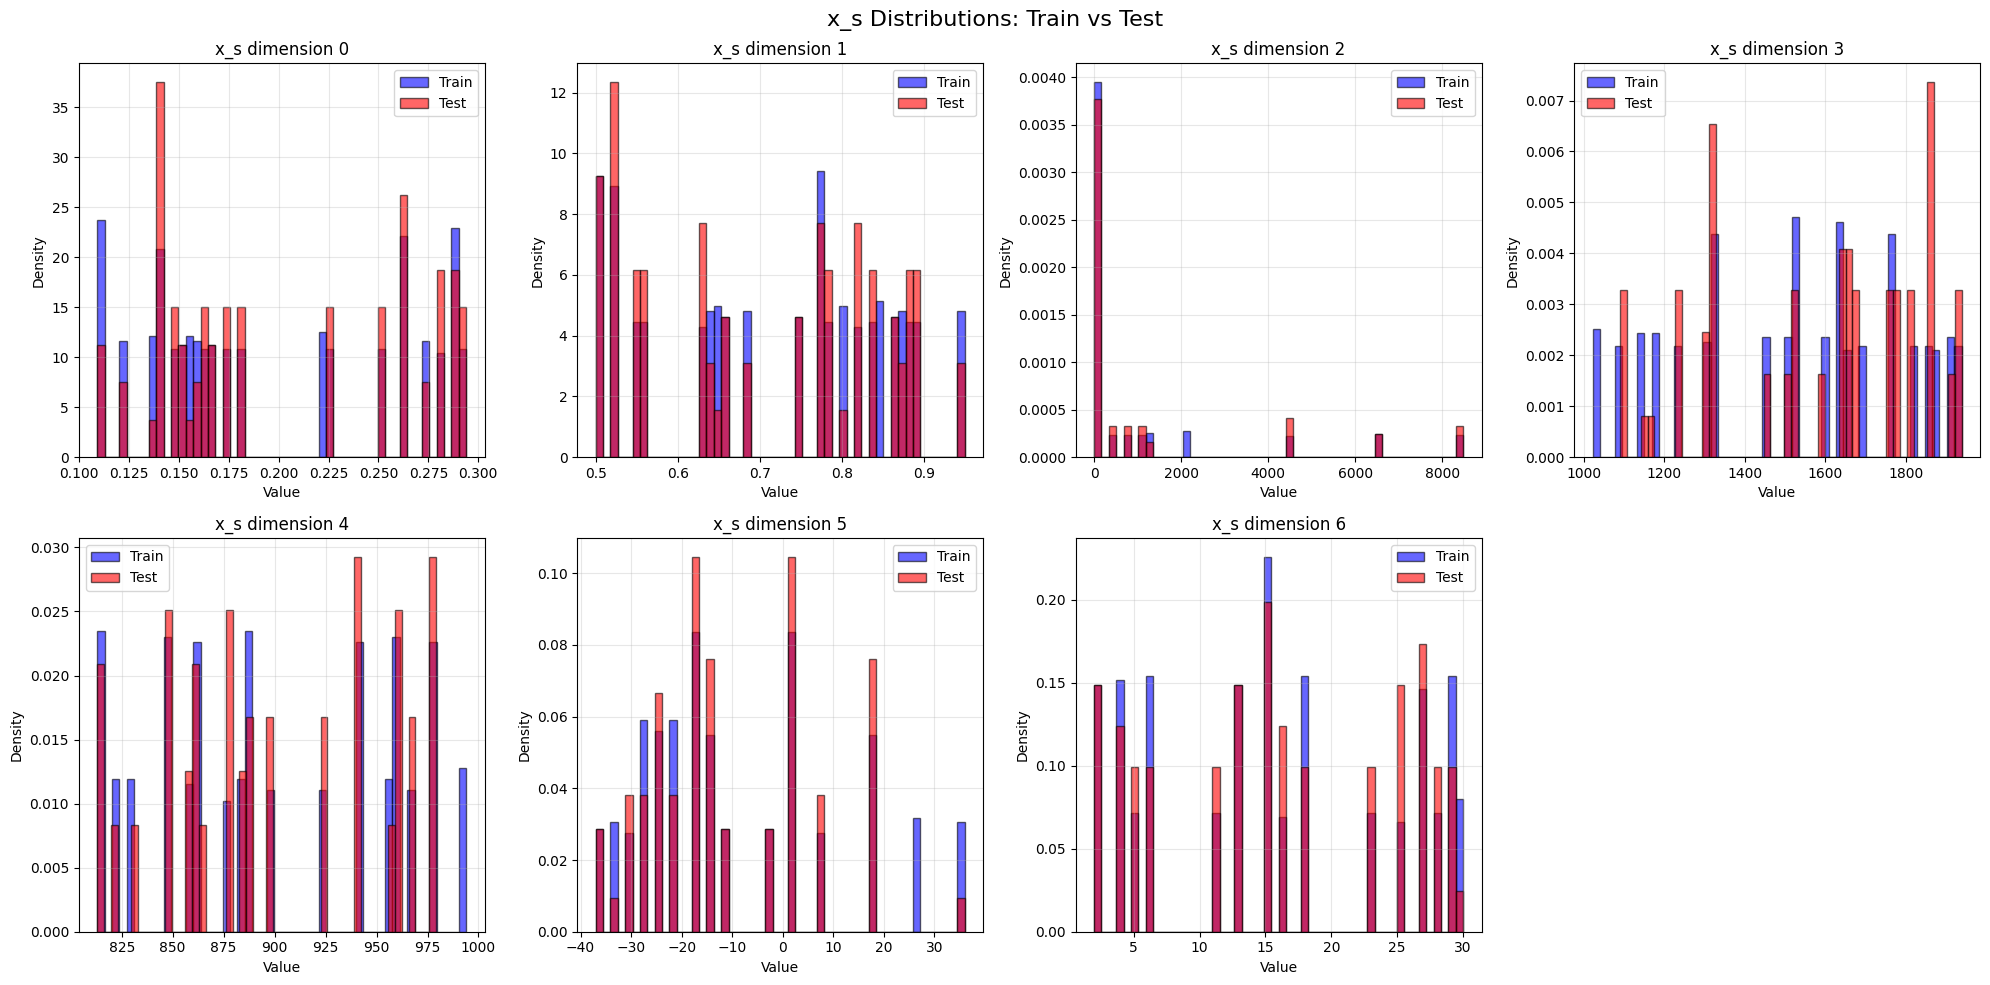

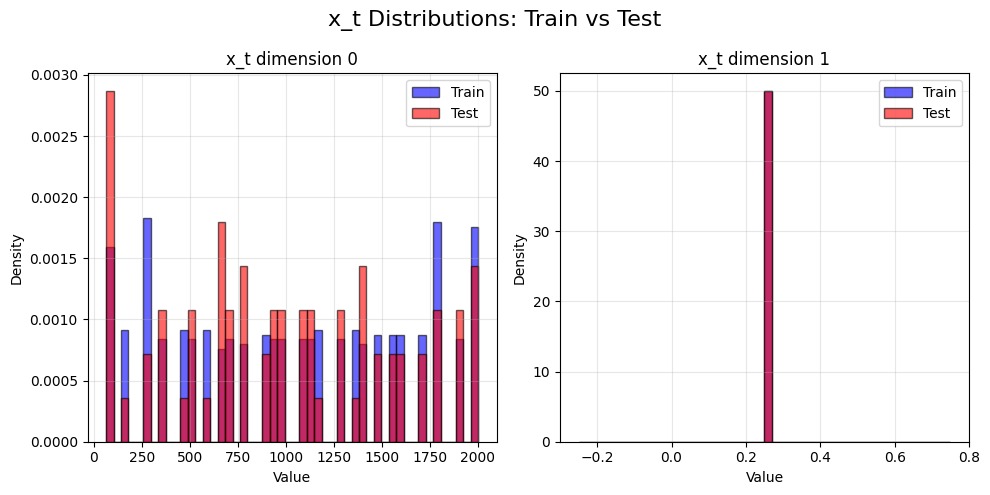

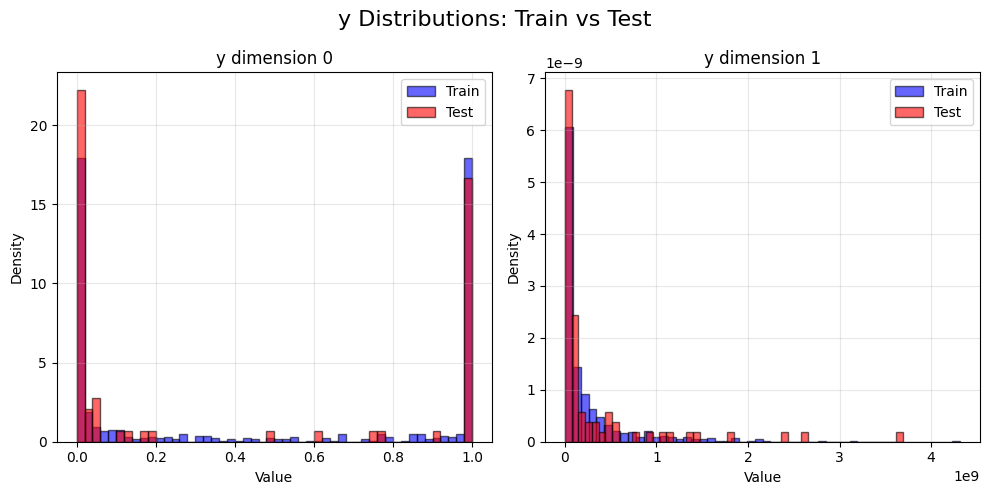


COMPARATIVE STATISTICS: TRAIN vs TEST

x_s statistics:
  Dimension 0:
    Train: mean=0.1951, std=0.0628, min=0.1090, max=0.2940
    Test:  mean=0.2014, std=0.0622, min=0.1090, max=0.2940
    Diff:  mean_diff=0.0062, std_diff=0.0006

  Dimension 1:
    Train: mean=0.7198, std=0.1385, min=0.5000, max=0.9500
    Test:  mean=0.7056, std=0.1432, min=0.5000, max=0.9500
    Diff:  mean_diff=0.0142, std_diff=0.0048
    ⚠️  WARNING: Potential distribution shift detected!

  Dimension 2:
    Train: mean=1037.3718, std=2165.2798, min=0.1300, max=8477.2002
    Test:  mean=1219.1661, std=2422.0085, min=0.1300, max=8477.2002
    Diff:  mean_diff=181.7943, std_diff=256.7288
    ⚠️  WARNING: Potential distribution shift detected!

  Dimension 3:
    Train: mean=1525.2793, std=272.6783, min=1021.0000, max=1939.0000
    Test:  mean=1587.4861, std=257.1009, min=1090.0000, max=1939.0000
    Diff:  mean_diff=62.2068, std_diff=15.5775
    ⚠️  WARNING: Potential distribution shift detected!

  Dimension 4:

In [6]:
# Paths
train_data_path = "/home/ubuntu/dev/data/numerical/1D_heat_transfer_n_space/high/train/1D_heat_transfer_n_space_samples.pt"
train_metadata_path = "/home/ubuntu/dev/data/numerical/1D_heat_transfer_n_space/high/train/1D_heat_transfer_n_space_samples_metadata.json"
test_data_path = "/home/ubuntu/dev/data/numerical/1D_heat_transfer_n_space/high/test/1D_heat_transfer_n_space_samples.pt"
test_metadata_path = "/home/ubuntu/dev/data/numerical/1D_heat_transfer_n_space/high/test/1D_heat_transfer_n_space_samples_metadata.json"

# Load data
print("Loading training data...")
train_data, train_metadata = load_data(train_data_path, train_metadata_path)

print("Loading test data...")
test_data, test_metadata = load_data(test_data_path, test_metadata_path)

# Visualize distributions
print("Generating comparative distribution plots...")
visualize_train_test_distributions(train_data, test_data, train_metadata, save_dir="/home/ubuntu/dev/outputs/figs")

print("Visualization complete! Plots saved in ./temp/")